In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Si" 
_path = datapath + "bananas/" + iso
_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    "p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    "p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ",
                                                            "tarpos.fX", "tarpos.fY", "tarpos.fZ"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        if isotope=="p_"+iso:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ","tarpos.fX", "tarpos.fY", "tarpos.fZ"])
            xtar = ak.nan_to_num(ak.flatten(dum["tarpos.fX"]))
            ytar = ak.nan_to_num(ak.flatten(dum["tarpos.fY"]))
            ztar = ak.nan_to_num(ak.flatten(dum["tarpos.fZ"]))
        else:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ"])
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        xpos = ak.flatten(dum["pos.fX"])
        ypos = ak.flatten(dum["pos.fY"])
        zpos = ak.flatten(dum["pos.fZ"])
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
            data_collection[isotope][detector_name]["pos.fX"].extend(xpos[mask])
            data_collection[isotope][detector_name]["pos.fY"].extend(ypos[mask])
            data_collection[isotope][detector_name]["pos.fZ"].extend(zpos[mask])
            if isotope=="p_"+iso:
                data_collection[isotope][detector_name]["tarpos.fX"].extend(xtar[mask])
                data_collection[isotope][detector_name]["tarpos.fY"].extend(ytar[mask])
                data_collection[isotope][detector_name]["tarpos.fZ"].extend(ztar[mask])
            else:
                continue
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si: 100%|██████████ 11/11 [00:42<00:00,  3.89s/file]
Processing p_Si: 100%|██████████ 11/11 [00:15<00:00,  1.39s/file]


#### Use this first banana plot to define regions of interest of a given peak. The peak value needs to found from a gaussian fit to the data, this has so far been done in root.

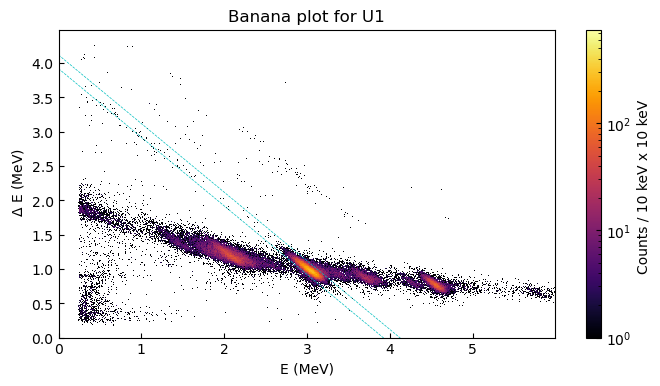

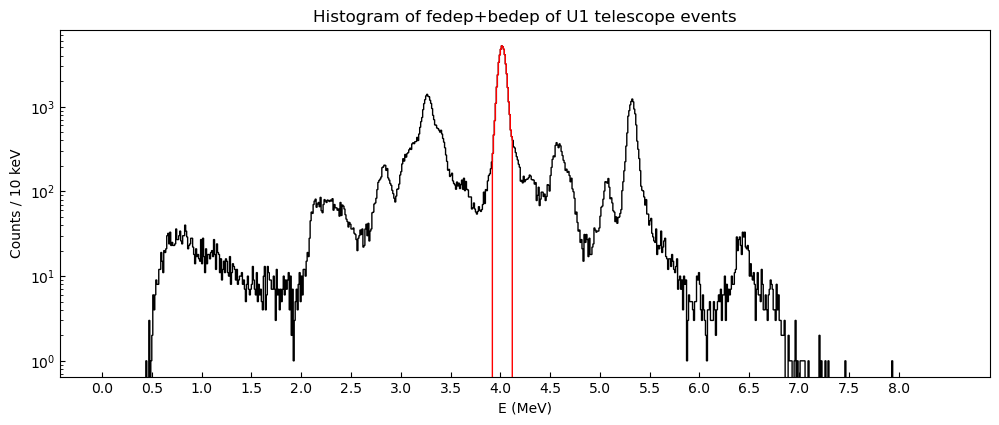

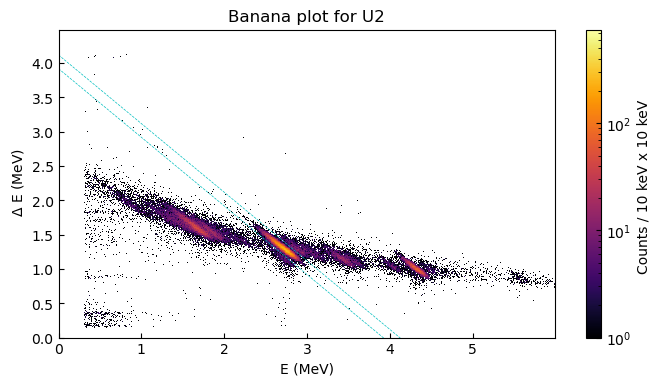

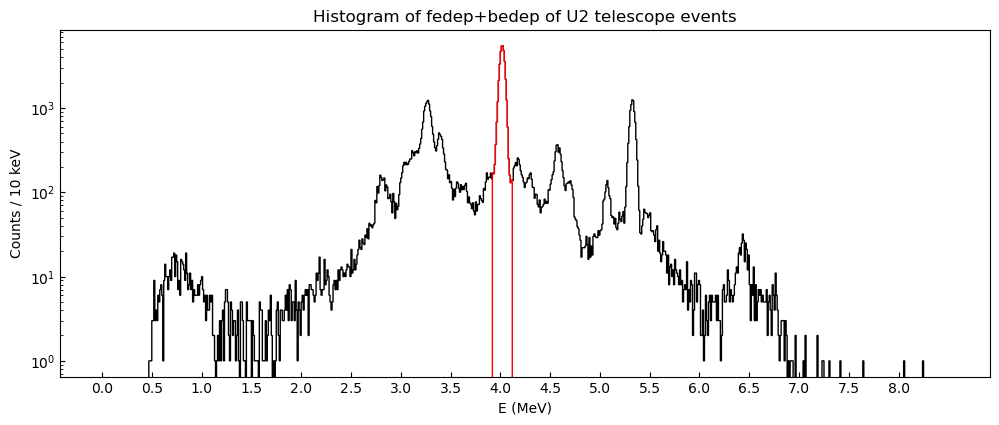

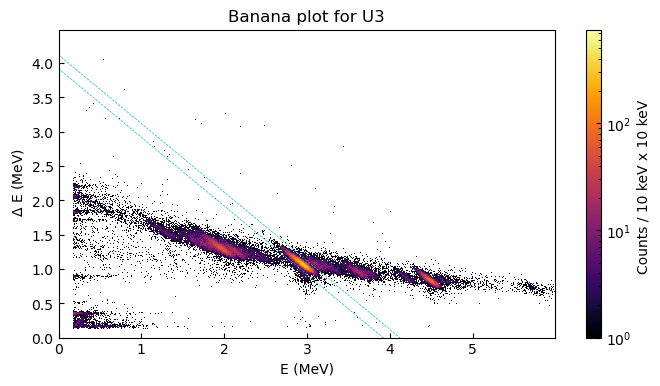

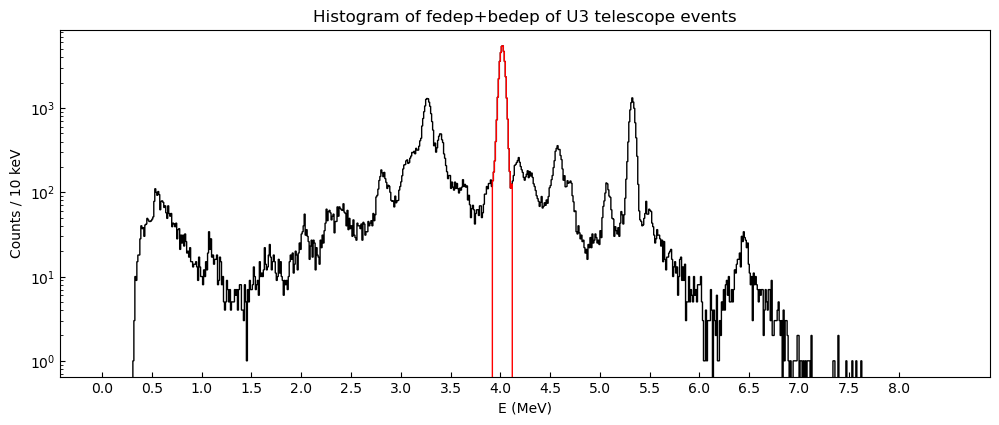

In [4]:

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"




lowlim= 3.92
uplim = 4.12

x = np.linspace(0, 6, 400)

y1 = -x + lowlim
y2 = -x + uplim 


### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(3):
    det = f"id{i}"
    plt.figure(figsize=(8,4))
    plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)       
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for U{i+1}")
    plt.plot(x,y1, ls='--', color='c', lw=0.5)
    plt.plot(x,y2, ls='--', color='c', lw=0.5)
 

    plt.plot()


    plt.figure(figsize=(12,4.5))
    æ = [a+b for a,b in zip(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"]) if a+b>0]
    plt.hist(æ, bins=np.arange(0,8.5,0.01), histtype='step', color='k')
    #plt.hist(data_collection[iso][det]["E"], bins=np.arange(0,8.5,0.01), histtype='step', color='k')

    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Histogram of fedep+bedep of U{i+1} telescope events")
    ø = [i for i in æ if lowlim<i<uplim]
    plt.hist(ø, bins=np.arange(0,8.5,0.01), histtype='step', color='r')
    plt.xticks(np.arange(0,8.5,0.5))
    #plt.hist(data_collection[iso][det]["Edep"], bins=np.arange(0,8.5,0.01), histtype='step', color='c')
    #plt.vlines(2.99, 0, 1e2, color='c', ls='--')
    #plt.vlines(3.877, 0, 1e2, color='c', ls='--')
    plt.show()


#### Now run the analysis "bananaexplorer" with the appropriate limits found from the previous plot. These limits are then also written down below in "peaks", "peak_vals" and also write down the number of peaks you wish to analyze

In [129]:

peaks = [(3.92,4.12)]
peak_vals = [4.093]
nr_peaks = len(peaks)

if nr_peaks != len(peak_vals) and nr_peaks != len(peaks) and len(peaks) != len(peak_vals):
    raise ValueError("The lengths of nr_peaks, peak_vals, and peaks do not match. Please set the appropriate values before continuing.")



def list_ini(n):
    return [[[] for _ in range(3)] for _ in range(n)]


### Values extracted from iso -> all values from base analysis
p_fi = list_ini(nr_peaks); p_bi=list_ini(nr_peaks); p_fedep=list_ini(nr_peaks); p_bedep=list_ini(nr_peaks)
p_app_angles=list_ini(nr_peaks)
p_posx= list_ini(nr_peaks);p_posy= list_ini(nr_peaks);p_posz= list_ini(nr_peaks)

## Values extracted from p_iso -> all values from peak analysis
p_calc_angles=list_ini(nr_peaks)


for j in range(len(peaks)):
    for i in range(3):
        det = f"id{i}"
        ## filling the values from base analysis
        for a,b,c,d,v, px,py,pz in zip(data_collection[iso][det]["fEdep"], data_collection[iso][det]["bEdep"],
                       data_collection[iso][det]["FI"], data_collection[iso][det]["BI"],data_collection[iso][det]["angle"],
                       data_collection[iso][det]["pos.fX"],data_collection[iso][det]["pos.fY"],data_collection[iso][det]["pos.fZ"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_fi[j][i].append(c)
                p_bi[j][i].append(d)
                p_fedep[j][i].append(a)
                p_bedep[j][i].append(b)
                p_app_angles[j][i].append(v)
                p_posx[j][i].append(px)
                p_posy[j][i].append(py)
                p_posz[j][i].append(pz)
            else:
                continue
        for a,b,v in zip(data_collection["p_"+iso][det]["fEdep"], data_collection["p_"+iso][det]["bEdep"],
                       data_collection["p_"+iso][det]["angle"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_calc_angles[j][i].append(v)



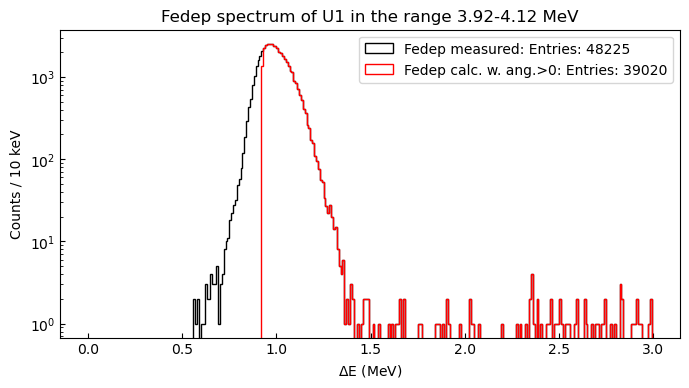

0.9235196316212145


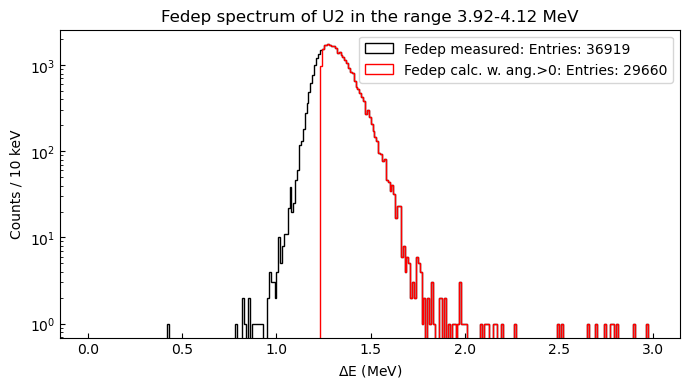

1.233667568362038


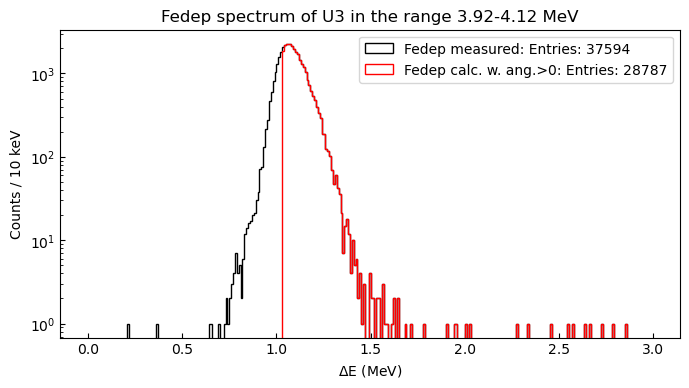

1.031013583951697


In [101]:
for j in range(len(peaks)):
    for i in range(3):
        plt.figure(figsize=(8,4))
        plt.xlabel(r"$\Delta$E (MeV)")
        plt.ylabel("Counts / 10 keV")
        plt.yscale('log')
        calc_fedeps = [a for a,v in zip(p_fedep[j][i],p_calc_angles[j][i]) if v>0] 
        plt.title(f"Fedep spectrum of U{i+1} in the range {peaks[j][0]}-{peaks[j][1]} MeV")
        plt.hist(p_fedep[j][i], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured: Entries: {len(p_fedep[j][i])}")
        plt.hist(calc_fedeps, bins=np.arange(0,3, 0.01), histtype='step', color='r', label=f"Fedep calc. w. ang.>0: Entries: {len(calc_fedeps)}")#({len(p1_f[i])/len(p1_fedep[i])*100:.2f}%)")
        plt.legend()
        plt.show()
        print(np.min(calc_fedeps))

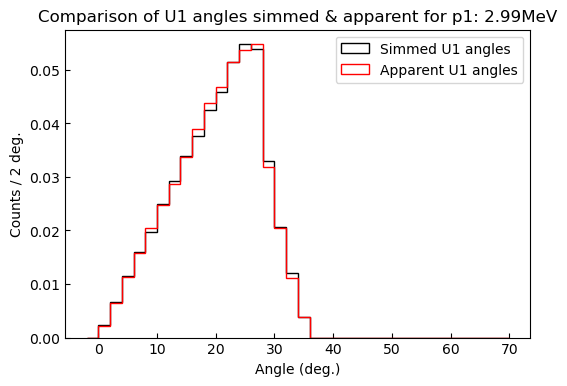

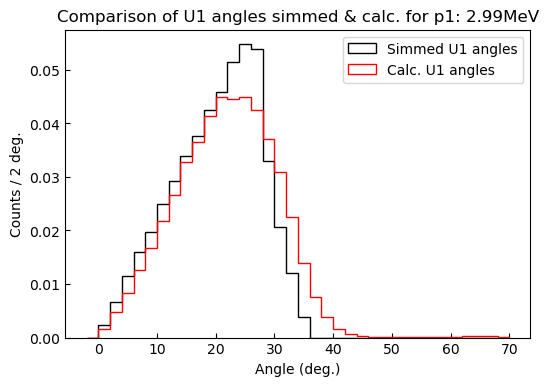

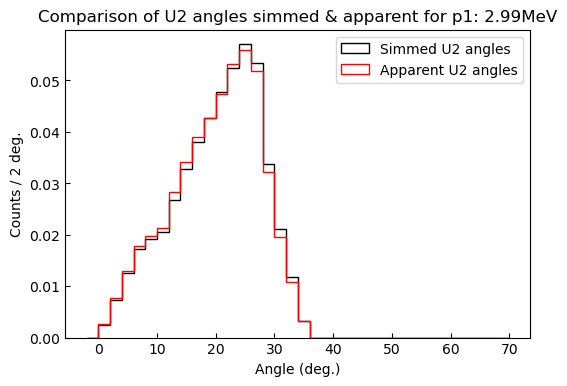

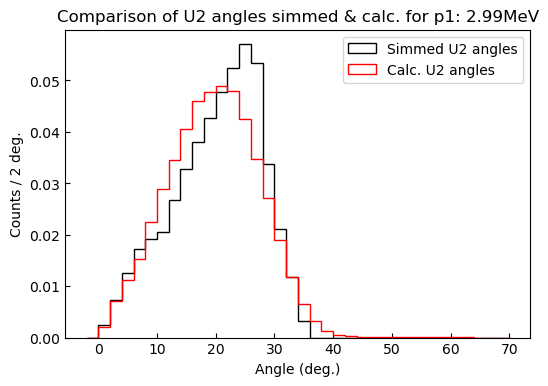

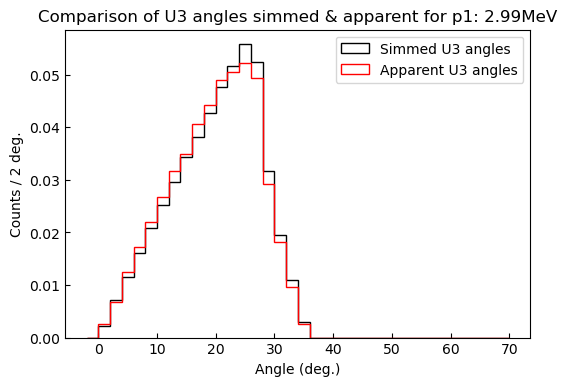

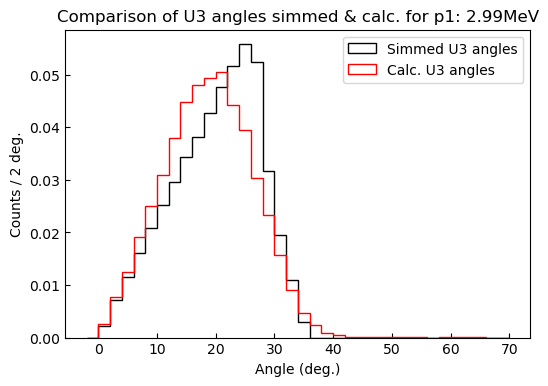

In [102]:
angfiles = ["U1Ang.dat", "U2Ang.dat", "U3Ang.dat"]
labs = ["U1 angles", "U2 angles", "U3 angles"]
### can expand to multiple peaks

for j,val in zip(range(len(peaks)), peaks):
    for i, a, l in zip(range(3),angfiles,labs):
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        fi, bi, angs, n = np.loadtxt(simpath+a, unpack=True)
        angs = np.rad2deg(angs)
        angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(p_app_angles[j][i], bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Apparent "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & apparent for {val}")
        ###
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        pa = [a for a in p_calc_angles[j][i] if a>0]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(pa, bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Calc. "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & calc. for {val}")


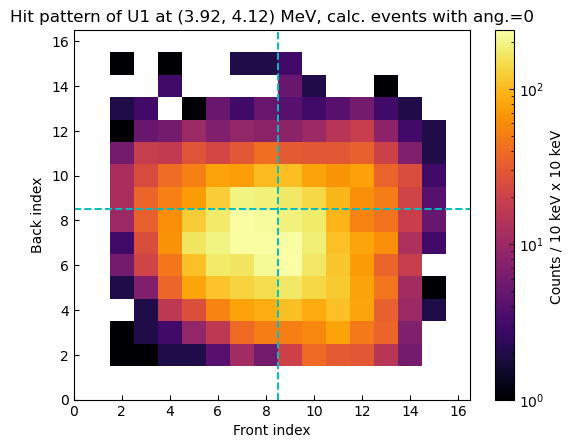

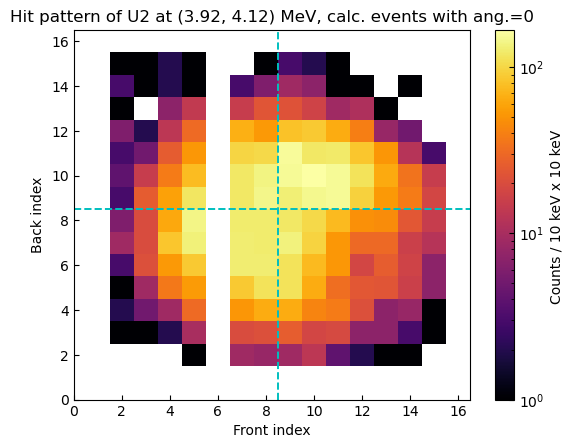

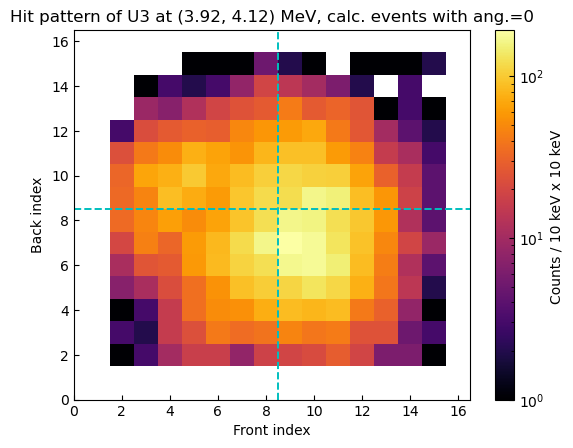

In [116]:

hists = list_ini(nr_peaks)
for j in range(len(peaks)):
    for i in range(3):
        calc_angles = np.array(p_calc_angles[j][i])#p1_angs[i])
        mask = (calc_angles ==0)
        fs = np.array(p_fi[j][i])#p1_angs_fi[i])
        bs = np.array(p_bi[j][i])#p1_angs_bi[i])
        fs = fs[mask]
        bs = bs[mask]
        plt.figure()
        plt.hist2d(fs, bs, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
            cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        hist= np.histogram2d(fs, bs, bins=(np.arange(1.5, 16.5, 1), np.arange(1.5,16.5,1)))
        hists[j][i] = hist
        plt.title(f"Hit pattern of U{i+1} at {peaks[j]} MeV, calc. events with ang.=0")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
        plt.xticks(np.arange(0,18, 2))
        plt.yticks(np.arange(0,18,2))
        plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
        plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')

        plt.show()


In [126]:
print(len(hists[0][0][1]))#; print(lenhists[0][1])

15


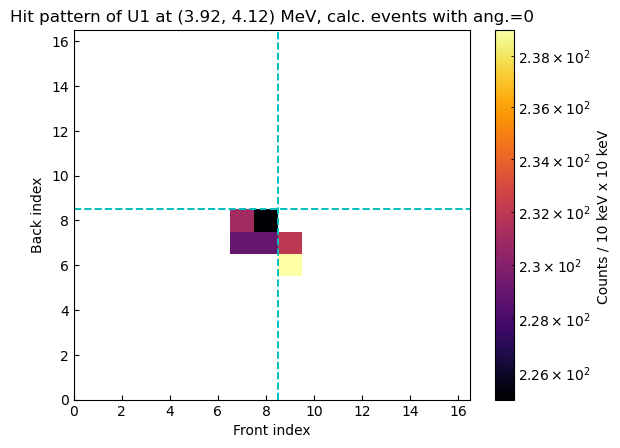

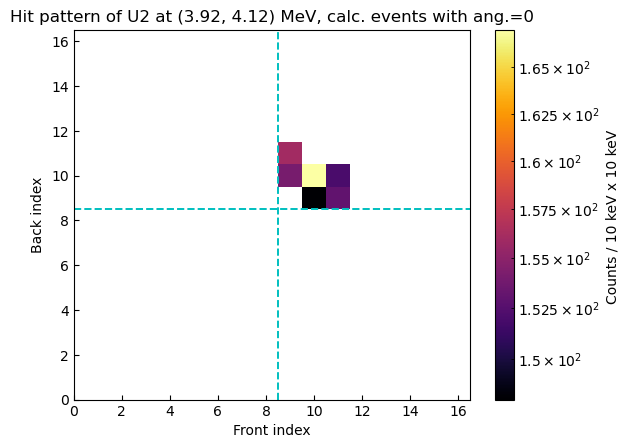

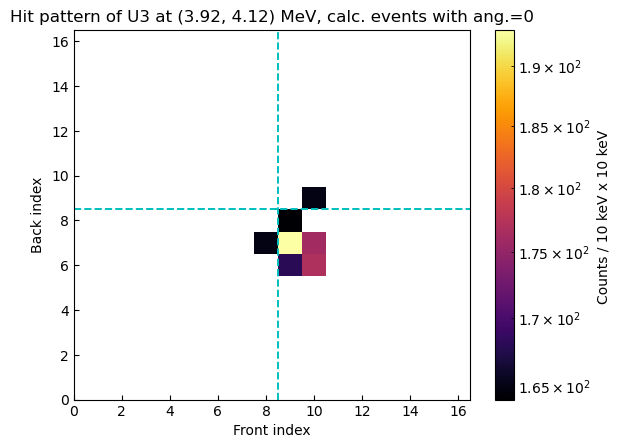

In [212]:
### i want to find the most intense pixel locations, this is ofcourse not very stringent and i should probably run
# it through a minimizer, ideally.

highhits = [220, 145, 160] ## array that states the number of counts which the most intense pixels are above
## perhaps this should be determined dynamically??
target_posx = list_ini(nr_peaks)
target_posy = list_ini(nr_peaks)
possx = list_ini(nr_peaks)
pixels = [(8,7), (10,10), (9,7)]


dirvecs = [(1,0,1), (1,0,-1), (-1,0,-1)]

maxf = list_ini(nr_peaks);maxb=list_ini(nr_peaks)
for j in range(len(peaks)):
    for h,m in zip(range(3),highhits):#for each weight matrix for the respective histogram
        
            for v in range(len(hists[j][h][0])): # for each FI rows containing all 16 BI values
                for i in range(len(hists[j][h][0][v])): #for each BI in the given FI row
                    if hists[j][h][0][v][i]>m: #if the value for the weight matrix is higher than the specifed limit we save the pixels
                        
                        maxf[j][h].append((hists[j][h][1][v]+hists[j][h][1][v+1])/2)
                        maxb[j][h].append((hists[j][h][2][i]+hists[j][h][2][i+1])/2)
    #print(maxf,maxb)

    for i in range(3):
        calc_angles = np.array(p_calc_angles[j][i])#p1_angs[i])
        mask = (calc_angles ==0)
        fs = np.array(p_fi[j][i])#p1_angs_fi[i])
        bs = np.array(p_bi[j][i])#p1_angs_bi[i])
        fs = fs[mask]
        bs = bs[mask]
        pxs = np.array(p_posx[j][i])[mask]
        pys = np.array(p_posy[j][i])[mask]
        pzs = np.array(p_posz[j][i])[mask]

        filt_f = [f for f,b in zip(fs,bs) if (f,b) in zip(maxf[j][i],maxb[j][i])]
        filt_b = [b for f,b in zip(fs,bs) if (f,b) in zip(maxf[j][i],maxb[j][i])]
        filt_pxs = [x for f,b,x in zip(fs,bs,pxs)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        filt_pys = [y for f,b,y in zip(fs,bs,pys)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        filt_pzs = [z for f,b,z in zip(fs,bs,pzs)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        
        for x,y,z in zip(filt_pxs,filt_pys,filt_pzs):
            #if i>1:
            #    Xpos = x-abs(z+0.3)
            #else:
            #    Xpos = abs(z+0.3)+x
            vec = dirvecs[i]
            
            somev = (-0.3-z)/vec[2]
            
            Xpos = x+somev*vec[0]
            #print("x",x, "z",z, "v", somev, "xpos",Xpos)
            target_posx[j][i].append(Xpos)
            target_posy[j][i].append(y)
            possx[j][i].append(x)
        
        
        plt.figure()
        plt.hist2d(filt_f, filt_b, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
           cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        hist= np.histogram2d(filt_f, filt_b, bins=(np.arange(1.5, 16.5, 1), np.arange(1.5,16.5,1)))
        #print(hist[0])
        
        plt.title(f"Hit pattern of U{i+1} at {peaks[j]} MeV, calc. events with ang.=0")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
        plt.xticks(np.arange(0,18, 2))
        plt.yticks(np.arange(0,18,2))
        plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
        plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')

        plt.show()


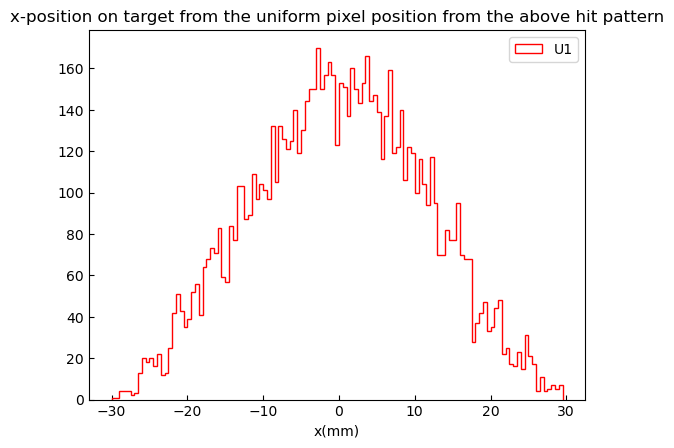

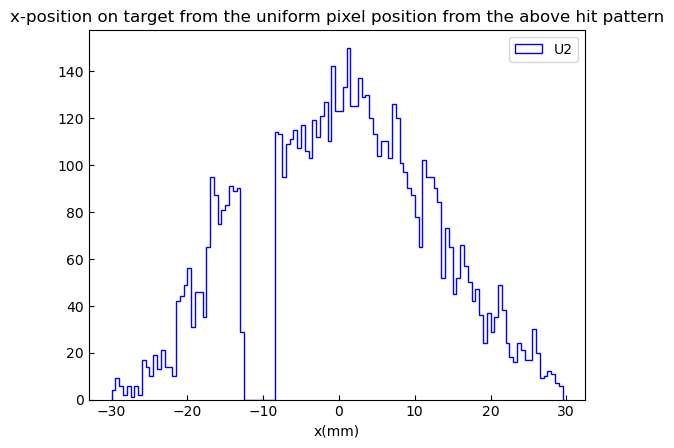

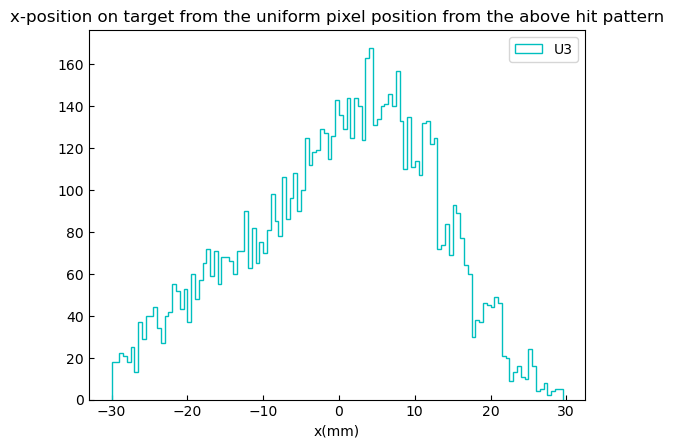

<Figure size 640x480 with 0 Axes>

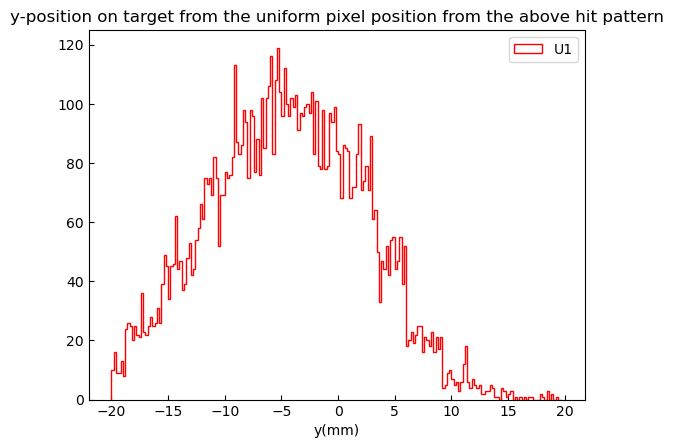

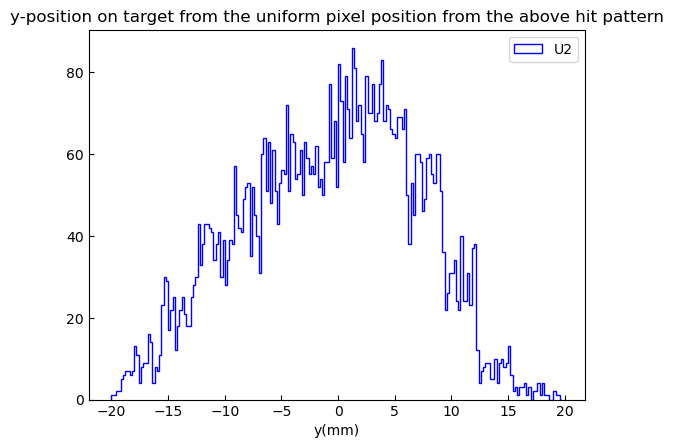

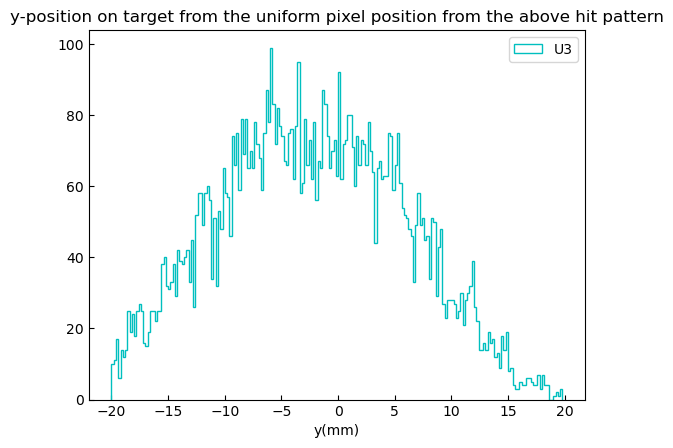

In [220]:

cols = ["r", "b", "c"]
pixels = [(8,7), (10,10), (9,7)]

for i in range(3):
    plt.figure()
    plt.hist(target_posx[0][i], bins=np.arange(-30,30,0.5),histtype='step', color=cols[i], label=f"U{i+1}")
    plt.legend()
    plt.title("x-position on target from the uniform pixel position from the above hit pattern")
    plt.xlabel("x(mm)")
plt.figure()
for i in range(3):
    plt.figure()
    plt.hist(target_posy[0][i], bins=np.arange(-20,20,0.2),histtype='step', color=cols[i], label=f"U{i+1}")
    plt.legend()
    plt.xlabel("y(mm)")
    plt.title("y-position on target from the uniform pixel position from the above hit pattern")

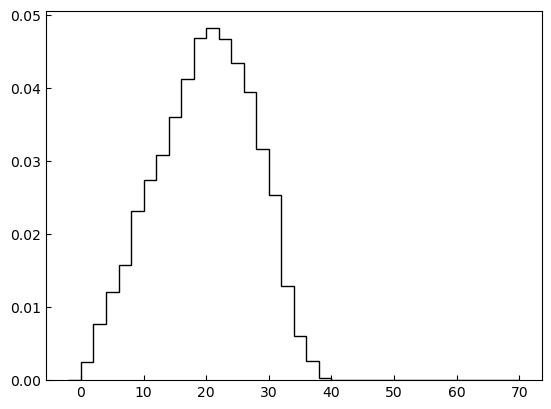

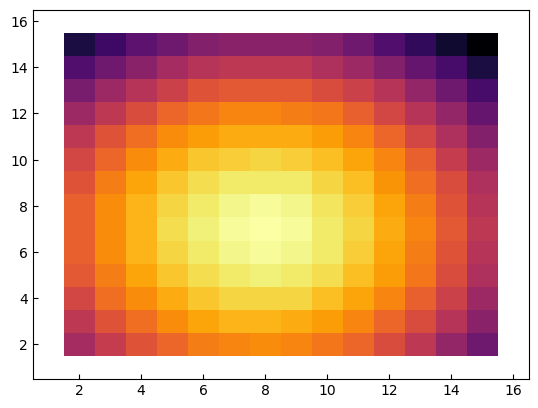

In [211]:
FI_list = list_ini(nr_peaks);BI_list = list_ini(nr_peaks)
fi, bi, angs, n = np.loadtxt(simpath+"newspot.dat", unpack=True)

angs = np.rad2deg(angs)
angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True)
for æ in range(2,16): #we exclude FI=1 and FI =16
    mask_fi = (fi==æ)
    if not np.any(mask_fi):
        continue
    else:
        masked_fi = fi[mask_fi]
        masked_bi = bi[mask_fi]
        masked_n = n[mask_fi]
    for ø in range(2,16): #we exclude BI=1 and BI=16
        mask_bi = (masked_bi == ø)       
        if not np.any(mask_bi):
            continue
        else:   
            doubmasked_n = masked_n[mask_bi] ## list of n's, they should all have the same value
            for å in range(0,int(doubmasked_n[0])):
                FI_list[0][0].append(æ)
                BI_list[0][0].append(ø)     
plt.figure()
plt.hist2d(np.array(FI_list[0][0])-0.5, np.array(BI_list[0][0])-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.show()

In [ ]:
#"""
tarx = [t for t in data_collection["p_"+iso]["id0"]["tarpos.fX"] if t!=0]
tary = [t for t in data_collection["p_"+iso]["id0"]["tarpos.fY"] if t!=0]
tarz = [t for t in data_collection["p_"+iso]["id0"]["tarpos.fZ"] if t!=0]
#plt.hist(tarx, bins=np.arange(-25,25,0.2),histtype='step', color='k')
#plt.hist2d(tarx,tary, bins=(np.arange(-25,25,9),np.arange(-25,25, 9)), 
#           cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)


hists = []
Fs = []; Bs= []
maxN = []; maxf=[];maxb=[]
xs=[];ys=[];fuckaf = []
dumf = [];dumb=[]
for i in range(3):
    det = f"id{i}"
    calc_angles = np.array(ps[i])#p1_angs[i])
    tarx = [t for t in data_collection["p_"+iso][det]["tarpos.fX"] if t!=0]
    posix = [y for t,y in zip(data_collection["p_"+iso][det]["tarpos.fX"],data_collection["p_"+iso][det]["pos.fZ"]) if t!=0]

    tary = [t for t in data_collection["p_"+iso][det]["tarpos.fY"] if t!=0]
    mask = (calc_angles ==0)
    fs = np.array(ps_fi[i])#p1_angs_fi[i])
    bs = np.array(ps_bi[i])#p1_angs_bi[i])
    F = fs[mask]
    B = bs[mask]
    Fs.append(fs[mask])
    Bs.append(bs[mask])
    #plt.figure()
    #plt.hist2d(fs[mask], bs[mask], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
    #    cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    hist= np.histogram2d(fs[mask], bs[mask], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)))
    hists.append(hist)

    for h in range(len(hist[0])):
        for v in range(len(hist[0][h])):
            if hist[0][h][v]==np.max(hist[0]):
                print(hist[0][h][v], hist[1][v], hist[2][h])
                maxf.append((hist[1][h]+hist[1][h+1])/2)
                maxb.append((hist[2][v]+hist[2][v+1])/2)
                tarmask = (fs[mask] == (hist[1][h]+hist[1][h+1])/2)
                tarxs = np.array(tarx)[tarmask]
                tarys = np.array(tary)[tarmask]
                pasd = np.array(posix)[tarmask]
                bs_dum = B[tarmask]
                #print(bs_dum)
                tarmask2 = (bs_dum == (hist[2][v]+hist[2][v+1])/2)
                #print("hopsalalaj", (hist[2][v]+hist[2][v+1])/2)
                tarxs = tarxs[tarmask2]
                tarys = tarys[tarmask2]
                pasd = pasd[tarmask2]
                xs.append(tarxs)
                ys.append(tarys)
                fuckaf.append(pasd)
                
                dumf.append(F)
                
    maxN.append(np.max(hist[0]))
    
    
#print(xs[0])    
#print(maxf, maxb, maxN)
plt.figure()
colors = ['r', 'b', 'k']
ls = ["U1", "U2", "U3"]
plt.hist(fuckaf[0], histtype='step', color='k')
#for x,c,l in zip(xs,colors,ls):
#    plt.hist(x, bins=np.arange(-10,10,1), histtype='step', color=c,label=l)
#plt.legend()
#plt.figure()
#for y,c,l in zip(ys,colors,ls):
#    plt.hist(y, bins=np.arange(-10,10,1), histtype='step', color=c,label=l)
#plt.legend()
#print()
#"""